# Normal Estimation from Depth Image

In [116]:
from copy import deepcopy

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Rectangle
from pydrake.all import RigidTransform, RotationMatrix, StartMeshcat

from manipulation import running_as_notebook
from manipulation.meshcat_utils import AddMeshcatTriad
from manipulation.mustard_depth_camera_example import MustardExampleSystem

In [117]:
# Start the visualizer.
meshcat = StartMeshcat()

INFO:drake:Meshcat listening for connections at http://localhost:7002


# Problem Description
In the lecture, we learned about estimating the point cloud normal vectors and surface curvations. For this exercise, you will investigate a slightly different approach. In particular, you will exploit the structure already presented in a depth image to avoid computing nearest neighbors. 

**These are the main steps of the exercise:**
1. Implement the `estimate_normal_by_nearest_pixels` method.
2. Come up with an example that breaks the `estimate_normal_by_nearest_pixels` method.

Run the cell below to set up the simulation environment.

In [118]:
class NormalEstimation:
    def __init__(self):
        diagram = MustardExampleSystem()
        context = diagram.CreateDefaultContext()

        # setup
        meshcat.SetProperty("/Background", "visible", False)

        # getting data
        self.point_cloud = diagram.GetOutputPort("camera0_point_cloud").Eval(context)
        self.rgb_im = diagram.GetOutputPort("camera0_rgb_image").Eval(context).data
        self.depth_im_read = (
            diagram.GetOutputPort("camera0_depth_image").Eval(context).data.squeeze()
        )
        self.depth_im = deepcopy(self.depth_im_read)
        self.depth_im[self.depth_im == np.inf] = 10.0
        label_im = (
            diagram.GetOutputPort("camera0_label_image").Eval(context).data.squeeze()
        )
        self.mask = label_im == 1

        # camera specs
        cam0 = diagram.GetSubsystemByName("camera0")
        cam0_context = cam0.GetMyMutableContextFromRoot(context)
        self.X_WC = cam0.body_pose_in_world_output_port().Eval(cam0_context)
        self.cam_info = cam0.depth_camera_info()

    def project_depth_to_pC(self, depth_pixel, uv=None):
        """
        project depth pixels to points in camera frame
        using pinhole camera model
        Input:
            depth_pixels: numpy array of (nx3) or (3,)
        Output:
            pC: 3D point in camera frame, numpy array of (nx3)
        """
        # switch u,v due to python convention
        v = depth_pixel[:, 0]
        u = depth_pixel[:, 1]
        Z = depth_pixel[:, 2]
        # read camera intrinsics
        cx = self.cam_info.center_x()
        cy = self.cam_info.center_y()
        fx = self.cam_info.focal_x()
        fy = self.cam_info.focal_y()
        X = (u - cx) * Z / fx
        Y = (v - cy) * Z / fy
        pC = np.c_[X, Y, Z]
        return pC

    def plot_scanning_window(self, u_range, v_range):
        """
        visualize the scanning window
        u_range: (u_start, u_end)
        v_range: (v_start, v_end)
        u, v are the 1st and 2nd axis of the image array
        """
        # switch u, v range to get x, y
        x0, x1 = v_range
        y0, y1 = u_range
        fig, ax = plt.subplots()
        ax.imshow(self.depth_im)
        ax.add_patch(Rectangle((x0, y0), x1 - x0, y1 - y0, alpha=0.5, fc="r"))

    def vis_normals(self, normals):
        """ """
        for i in range(len(normals)):
            name = "normal_vec_{}".format(i)
            AddMeshcatTriad(meshcat, name, length=0.01, radius=0.001, X_PT=normals[i])


def bbox(img):
    a = np.where(img != 0)
    bbox = ([np.min(a[0]), np.max(a[0])], [np.min(a[1]), np.max(a[1])])
    return bbox


env = NormalEstimation()
mask = env.mask
depth_im = env.depth_im

The object of interest is the mustard bottle. Our goal in this exercise is to compute the estimate of point cloud normals of the mustard bottle from a depth image. The depth image is visualized below.

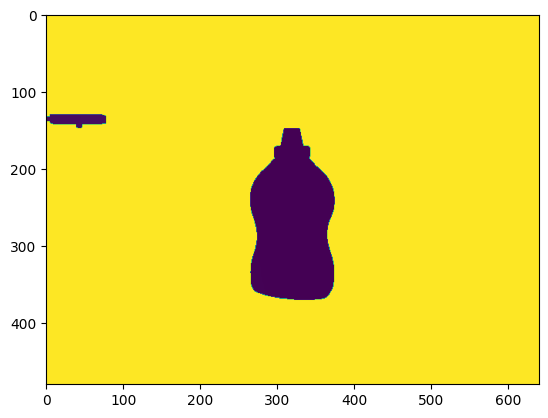

In [119]:
plt.imshow(depth_im)

The core idea of the approach is to exploit the fact that a depth image already includes spatial information among pixels. For example, for a selected pixel, the pixels that surround it are likely to be its nearest neighbors. Therefore, instead of computing nearest neighbors, we can instead use the nearest pixels in place of nearest neighbors. 

The cell below provides a sequence of screenshots of the method, where a square/rectangular window moves across the depth image. All pixels in the sliding window is used to compute the normal vector of the center point of the window. In your implementation below, you will use a smaller window and a smaller step size to get better accuracy.

In [ ]:
uv_step = 40
v_bound, u_bound = bbox(mask)

for v in range(v_bound[0], v_bound[1], uv_step):
    for u in range(u_bound[0], u_bound[1], uv_step):
        center = [v, u]
        u_length = 30
        v_length = 30
        if running_as_notebook:
            env.plot_scanning_window(
                [center[0] - v_length, center[0] + v_length + 1],
                [center[1] - u_length, center[1] + u_length + 1],
            )

## Mapping Depth Image to Point Cloud

Note that pixel indices of a depth image is not a valid position measurement in the 3D world. Fortunately, there is a simple mapping from pixel locations to poses in the 3D world, and it is called the [pinhole camera model](https://docs.opencv.org/3.4/d9/d0c/group__calib3d.html). We have helped you map all pixels of the depth image to points in the camera frame in the cell below. In case you need to gain direct access to this mapping, please refer to the `project_depth_to_pC` method in the `NormalEstimation` class.

The diagram below is found from [OpenCV documentation](https://docs.opencv.org/3.4/d9/d0c/group__calib3d.html). Note that the $u$ and $v$ directions are reversed in Python due to the difference in convention.

![](https://docs.opencv.org/3.4/pinhole_camera_model.png)

In [121]:
img_h, img_w = depth_im.shape
v_range = np.arange(img_h)
u_range = np.arange(img_w)
depth_u, depth_v = np.meshgrid(u_range, v_range)
depth_pnts = np.dstack([depth_v, depth_u, depth_im])
depth_pnts = depth_pnts.reshape([img_h * img_w, 3])
# point poses in camera frame
pC = env.project_depth_to_pC(depth_pnts)

## Computing Surface Normals by Nearest Pixels
Now we should be able to calculate the surface normals. Recall from section 5.5.2 of the textbook, in each sliding window we can use the points to construct a data matrix (also known as a *scatter matrix*) **W** which exhibits special properties that allows us to estimate the local normals. 

**Problem 5.2.a** [2pts] Which eigenvector of **W** corresponds to the vector normal to the points in the sliding window? Assume we want to specify a normal frame whose z-axis corresponds to the vector normal to the points in the sliding window. How can you use the eigenvectors of **W** to create a rotation matrix representing the desired orientation of the normal frame. Justify that your answer represents a valid rotation matrix.

5.2 a: The eigenvector corresponding to the largest eigenvalue of the data matrix corresponds to the direction of least curvature. To find the desired rotation of the normal frame, we set up and solve for the following equation. $$V^TSV = D$$ The matrix $S$ is the matrix rotating from the camera frame to the normal frame.
To justify that $S$ is a valid rotation matrix, we can take $det(S)$ and make sure the value is 1. Since W is symmetric, it produces orthogonal eigenvectors (from the notes). We are multiplying two orthogonal matrices to produce S.

**Problem 5.2.b** [4pts] **Complete the implementation of the `estimate_normal_by_nearest_pixels` below.** 

Note that locations of sliding windows are provided to you for the ease of grading. The pose of the depth camera is `X_WC`, **it is a different depth camera from the one shown in the meshcat visualizer**. Lastly, **make sure the +z axis of the normal frame points outward, toward the depth camera (different from the one shown in the meshcat visualizer)**. It will be useful to review section 5.5.2 in the notes for computing the normal estimate. 

HINT: consider using *np.linalg.eigh*

In [207]:
X_WC = env.X_WC


def estimate_normal_by_nearest_pixels(X_WC, pC, uv_step=10):
    """
    compute the surface normals from the nearest pixels (by a sliding window)
    Input:
        X_WC: RigidTransform of the camera in world frame
        pC: 3D points computed from the depth image in the camera frame
        uv_step: recommended step size for the sliding window (see codes below)
    Output:
        normals: a list of RigidTransforms of the normal frames in world frame.
                 The +z axis of the normal frame is the normal vector, it should
                 points outward (towards the camera)
    """
    normals = []
    v_bound, u_bound = bbox(mask)
    pC = pC.reshape(img_h, img_w, 3)
    p_WC = X_WC.translation()
    for v in range(v_bound[0], v_bound[1], uv_step):
        for u in range(u_bound[0], u_bound[1], uv_step):
            # v = 178 # DEBUG
            # u = 325 # DEBUG
            # center of the window at depth_im[u,v]
            center = [v, u]
            u_length = 3
            v_length = 3
            # side of the window
            v_range = np.arange(max(v - v_length, 0), min(v + v_length + 1, img_h - 1))
            u_range = np.arange(max(u - u_length, 0), min(u + u_length + 1, img_w - 1))

            ### my code here

            # pC_window is the 49 points in the window and their depth values
            pC_window = pC[v_range, :, :][:, u_range, :].reshape(-1, 3) # list of 49 points with xyz coordinates in the window

            # Perform PCA
            pstar_C = np.mean(pC_window, axis=0)
            prel_C = pC_window - pstar_C
            W = np.matmul(prel_C.T, prel_C)
            w, V = np.linalg.eigh(W) # eigh sorts the return values in ascending order

            # The normal vector is the eigenvector corresponding to the smallest eigenvalue
            R = np.fliplr(V)

            # Handle improper rotations
            R = R @ np.diag([1, 1, np.linalg.det(R)])

            normal = R[:,2]
            normal_world = X_WC.rotation().multiply(normal)

            # Ensure the normal vector points outward (toward the camera)
            if ((p_WC - X_WC.multiply(pstar_C)).dot(normal_world)) < 0:
                R = R @ np.diag([1, -1, -1])
            
            # Transform from camera to world frame using X_WC
            pstar_W = X_WC.multiply(pstar_C)

            # mat = RotationMatrix(R)
            mat = X_WC.rotation().multiply(RotationMatrix(R))

            # Append the normal vector to the list
            normals.append(RigidTransform(RotationMatrix(mat), pstar_W))

    return normals

In [208]:
meshcat.Delete()
normals = estimate_normal_by_nearest_pixels(X_WC, pC)
env.vis_normals(normals)


## Normal Vector Estimation with Noisy Depth


The depth image tested in the first part of this exercise is a perfect depth image with no noise and missing values. Now imagine what will happen when noises and outliers are presented in the same depth image. 

**Problem 5.2.c** [2pts] **Illustrate a counter-example illustrating a case where the scanning window method cannot produce a good normal estimate.**

The algorithm doesn't work in any cases of occlusion or noise. The most obvious example of noise is discontinuities in the point cloud. Depth noise may produce sharp surface features in what might be an otherwise relatively flat surface, and this could shift the calculation of the normal by finding a local minimum in a "pocket" created by noisy depth data. Similarly, if the image is occluded or the shape has hidden concave surfaces, the normal vector estimation might have missing depth values that can mislead the algorithm.

## How will this notebook be Graded?

If you are enrolled in the class, this notebook will be graded using [Gradescope](www.gradescope.com). You should have gotten the enrollement code on our announcement in Piazza. 

For submission of this assignment, you must do two things. 
- Download and submit the notebook `normal_estimation_depth.ipynb` to Gradescope's notebook submission section, along with your notebook for the other problems.
- Answer 5.2.a and 5.2.c in the written section of Gradescope as a part of your `pdf` submission. 

We will evaluate the local functions in the notebook to see if the function behaves as we have expected. For this exercise, the rubric is as follows:
- [2 pts] Identify which eigenvector of the data matrix W corresponds to the surface normal vector and explain how the eigenvectors can be used to compute the transform of the normal frame expressed in the camera frame.
- [4 pts] `estimate_normal_by_nearest_pixels` must be implemented correctly. 
- [2 pts] Provide a reasonable scenario that breaks the `estimate_normal_by_nearest_pixels` method.

In [209]:
from manipulation.exercises.clutter.test_normal import TestNormal
from manipulation.exercises.grader import Grader

Grader.grade_output([TestNormal], [locals()], "results.json")
Grader.print_test_results("results.json")

Total score is 4/4.

Score for Testing the normal vectors is 4/4.


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=a9f4175d-ea21-49c3-83c9-e5c3a0936239' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>